# WISDM Activity Classification - Tier 1 Implementation

This notebook implements:
1. **SMOTE** for minority class oversampling
2. **Feature Engineering** - Z-direction, vertical ratios
3. **XGBoost** classifier (handles class overlap better than simple models)

Training on: `client_C.csv`

## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [3]:
# Load client_C data
data_path = '../WISDM_ar_v1.1/client_C.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['class'].value_counts())
print(f"\nData snippet:")
df.head()

Dataset shape: (1929, 46)

Columns: ['UNIQUE_ID', 'user', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'RESULTANT', 'class']

Class distribution:
class
Walking       691
Jogging       669
Upstairs      207
Downstairs    168
Sitting       110
Standing       84
Name: count, dtype: int64

Data snippet:


,UNIQUE_ID,user,X0,X1,X2,X3,X4,X5,X6,X7,...,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,class
0,1,33,0.04,0.09,0.14,0.12,0.11,0.10,0.08,0.13,...,293.94,1550.00,3.29,7.21,4.00,4.05,8.17,4.05,11.96,Jogging
1,2,33,0.12,0.12,0.06,0.07,0.11,0.10,0.11,0.09,...,269.44,1233.33,4.23,6.88,4.05,5.43,8.19,5.43,12.05,Jogging
2,3,33,0.14,0.09,0.11,0.09,0.09,0.11,0.12,0.08,...,248.65,1780.00,4.18,6.89,4.07,5.55,8.19,5.55,11.99,Jogging
3,4,33,0.06,0.10,0.09,0.09,0.11,0.07,0.12,0.10,...,709.09,1380.00,2.26,4.13,2.49,2.87,4.95,2.87,10.69,Walking
4,5,33,0.12,0.11,0.10,0.08,0.10,0.14,0.10,0.11,...,3300.00,1775.00,2.29,3.94,2.41,3.08,4.64,3.08,10.80,Walking


## 3. Feature Engineering

Create new features to help distinguish overlapping classes:
- **Z_direction**: Sign of vertical acceleration (helps Upstairs vs Downstairs)
- **vertical_intensity**: Z standard deviation relative to Y (stairs are "bumpier")
- **Z_to_resultant_ratio**: How much of movement is vertical
- **movement_stability**: Inverse of overall std (helps Sitting vs Standing)

In [4]:
def engineer_features(df):
    """Create new discriminative features for overlapping classes"""
    df = df.copy()
    
    # For Upstairs vs Downstairs
    # Z_direction: positive = downstairs tendency, negative = upstairs tendency
    df['Z_direction'] = np.sign(df['ZAVG'])
    
    # Vertical intensity ratio: how bumpy is vertical vs forward movement
    df['vertical_intensity'] = df['ZSTANDDEV'] / (df['YSTANDDEV'] + 0.001)  # avoid div by 0
    
    # Z contribution to overall movement
    df['Z_to_resultant'] = df['ZAVG'].abs() / (df['RESULTANT'] + 0.001)
    
    # For Sitting vs Standing
    # Movement stability (low values = more stable = likely sitting)
    df['movement_stability'] = 1 / (df['XSTANDDEV'] + df['YSTANDDEV'] + df['ZSTANDDEV'] + 0.001)
    
    # X-axis micro-movement ratio (sitting tends to have more X variation relative to Y)
    df['X_to_Y_std_ratio'] = df['XSTANDDEV'] / (df['YSTANDDEV'] + 0.001)
    
    # Absolute deviation ratios
    df['vertical_deviation_ratio'] = df['ZABSOLDEV'] / (df['YABSOLDEV'] + 0.001)
    
    # Range features from the 10-timestep data
    z_cols = [f'Z{i}' for i in range(10)]
    x_cols = [f'X{i}' for i in range(10)]
    y_cols = [f'Y{i}' for i in range(10)]
    
    df['Z_range'] = df[z_cols].max(axis=1) - df[z_cols].min(axis=1)
    df['X_range'] = df[x_cols].max(axis=1) - df[x_cols].min(axis=1)
    df['Y_range'] = df[y_cols].max(axis=1) - df[y_cols].min(axis=1)
    
    return df

# Apply feature engineering
df = engineer_features(df)
print(f"New shape after feature engineering: {df.shape}")
print(f"\nNew features added:")
new_features = ['Z_direction', 'vertical_intensity', 'Z_to_resultant', 
                'movement_stability', 'X_to_Y_std_ratio', 'vertical_deviation_ratio',
                'Z_range', 'X_range', 'Y_range']
print(new_features)

New shape after feature engineering: (1929, 55)

New features added:
['Z_direction', 'vertical_intensity', 'Z_to_resultant', 'movement_stability', 'X_to_Y_std_ratio', 'vertical_deviation_ratio', 'Z_range', 'X_range', 'Y_range']


## 4. Prepare Features and Labels

In [5]:
# Define feature columns (exclude non-feature columns)
exclude_cols = ['UNIQUE_ID', 'user', 'class']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Separate features and target
X = df[feature_cols].values
y = df['class'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nClasses: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")

Number of features: 52
Features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'RESULTANT', 'Z_direction', 'vertical_intensity', 'Z_to_resultant', 'movement_stability', 'X_to_Y_std_ratio', 'vertical_deviation_ratio', 'Z_range', 'X_range', 'Y_range']

Classes: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']
Encoded as: [0, 1, 2, 3, 4, 5]


## 5. Train-Test Split

In [6]:
# Stratified split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # Important for imbalanced data!
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

Training set: 1543 samples
Test set: 386 samples

Training class distribution:
  Downstairs: 134 (8.7%)
  Jogging: 535 (34.7%)
  Sitting: 88 (5.7%)
  Standing: 67 (4.3%)
  Upstairs: 166 (10.8%)
  Walking: 553 (35.8%)


## 6. Feature Scaling

In [7]:
# Scale features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"X_train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")

Features scaled successfully!
X_train mean: -0.0000, std: 0.9903


## 7. Apply SMOTE for Class Balancing

SMOTE creates synthetic samples for minority classes by interpolating between existing samples.

In [8]:
print("Before SMOTE:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c}")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c}")

print(f"\nTraining samples: {len(y_train)} -> {len(y_train_resampled)}")

Before SMOTE:
  Downstairs: 134
  Jogging: 535
  Sitting: 88
  Standing: 67
  Upstairs: 166
  Walking: 553

After SMOTE:
  Downstairs: 553
  Jogging: 553
  Sitting: 553
  Standing: 553
  Upstairs: 553
  Walking: 553

Training samples: 1543 -> 3318


## 8. Reshape Data and One-Hot Encode for CNN

In [ ]:
# Reshape features for Conv1D: [samples, timesteps, features]
# Here, we treat each feature as a separate channel over a single timestep.
X_train_cnn = np.expand_dims(X_train_resampled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

# One-hot encode labels
n_classes = len(label_encoder.classes_)
y_train_cnn = to_categorical(y_train_resampled, num_classes=n_classes)
y_test_cnn = to_categorical(y_test, num_classes=n_classes)

print(f"Original X_train shape: {X_train_resampled.shape}")
print(f"Reshaped X_train for CNN: {X_train_cnn.shape}")
print(f"Original y_train shape: {y_train_resampled.shape}")
print(f"One-hot encoded y_train for CNN: {y_train_cnn.shape}")

## 9. Define and Train 1D CNN Model

In [ ]:
n_features = X_train_cnn.shape[1]

cnn_model = Sequential([
    # Input layer
    tf.keras.layers.Input(shape=(n_features, 1)),
    
    # Convolutional layers
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Dropout(0.3),
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    # Flatten and Dense layers
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(n_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
cnn_model.summary()

# Train the model
print("\nTraining CNN model...")
history = cnn_model.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_cnn, y_test_cnn),
    verbose=1
)
print("\nTraining complete!")

## 10. Evaluation

In [ ]:
# Make predictions
y_pred_probs = cnn_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

# Note: y_test is still integer encoded, which is what we need for comparison

# Calculate metrics
accuracy = (y_pred == y_test).mean()
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("=" * 50)
print("CNN MODEL PERFORMANCE")
print("=" * 50)
print(f"Accuracy:          {accuracy * 100:.2f}%")
print(f"Balanced Accuracy: {balanced_acc * 100:.2f}%")
print(f"F1-Score (Macro):  {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

In [11]:
# Detailed classification report
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Downstairs       0.74      0.68      0.71        34
     Jogging       0.97      0.98      0.97       134
     Sitting       0.92      1.00      0.96        22
    Standing       1.00      1.00      1.00        17
    Upstairs       0.85      0.83      0.84        41
     Walking       0.96      0.97      0.97       138

    accuracy                           0.94       386
   macro avg       0.91      0.91      0.91       386
weighted avg       0.93      0.94      0.93       386



In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

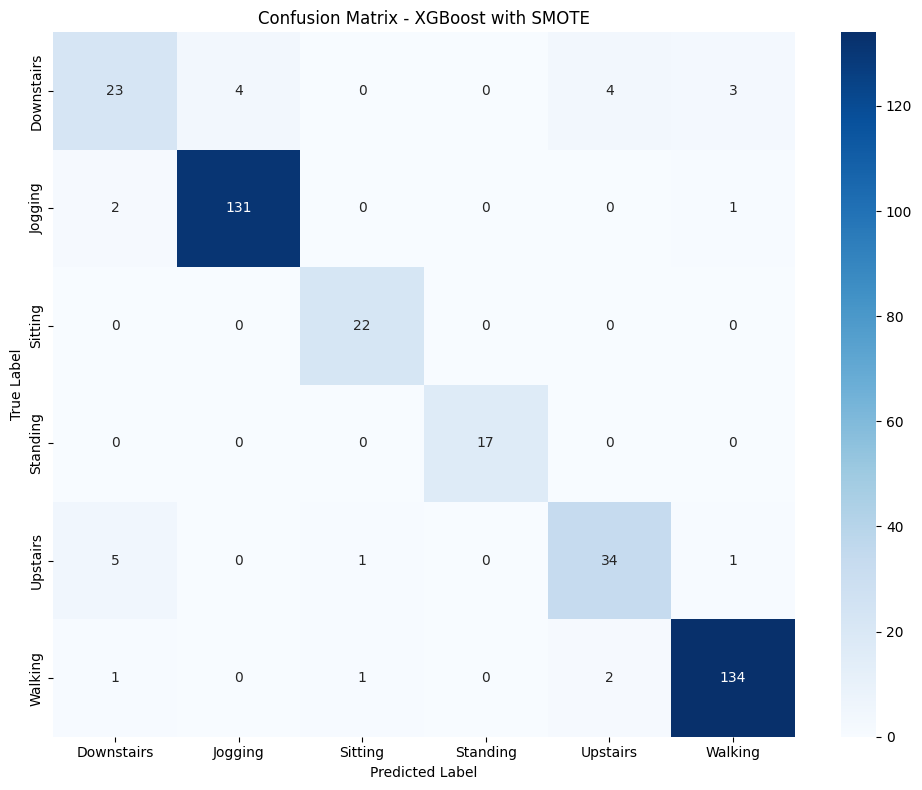

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN with SMOTE')
plt.tight_layout()
plt.show()

## 10. Feature Importance Analysis

See which features are most useful for classification (including our engineered features).

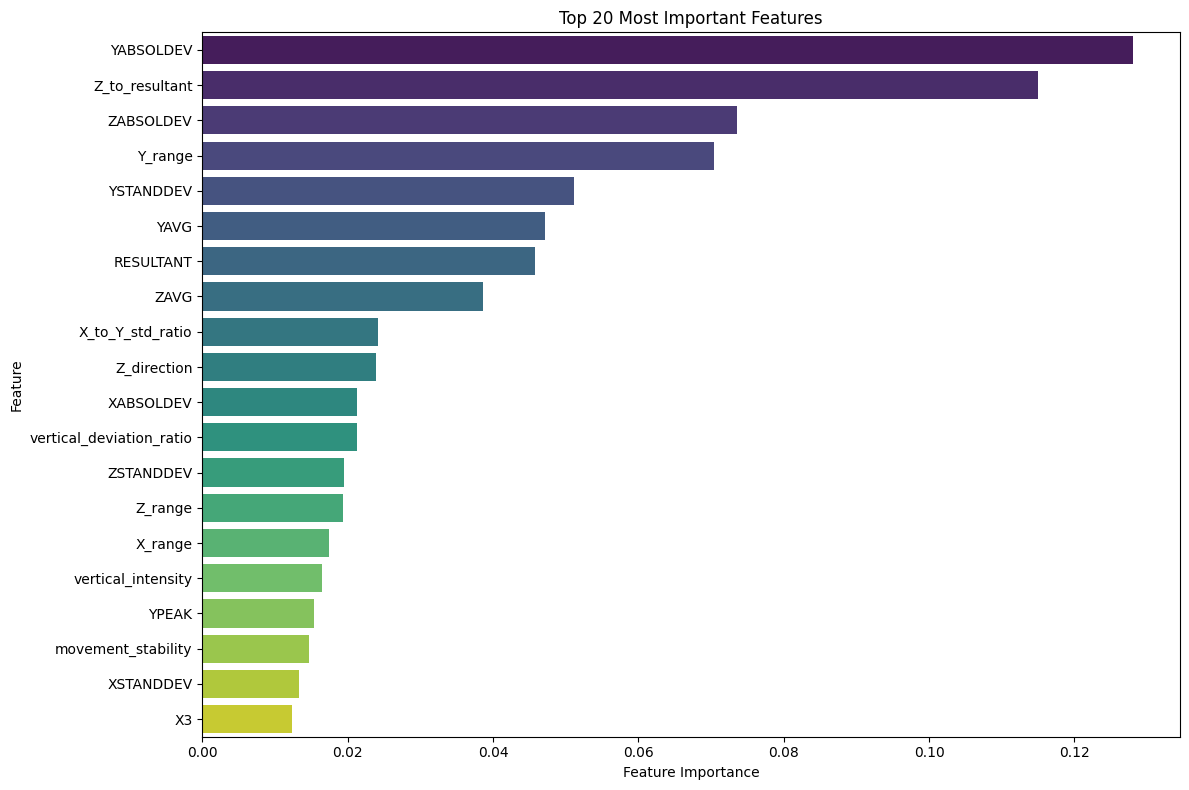


Engineered Features Importance:
                 feature  importance
          Z_to_resultant    0.114967
                 Y_range    0.070345
        X_to_Y_std_ratio    0.024175
             Z_direction    0.023834
vertical_deviation_ratio    0.021304
                 Z_range    0.019394
                 X_range    0.017370
      vertical_intensity    0.016442
      movement_stability    0.014703


In [13]:
# Get feature importances
importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_n = 20
sns.barplot(data=feature_importance_df.head(top_n), x='importance', y='feature', palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

# Highlight engineered features
print("\nEngineered Features Importance:")
engineered = feature_importance_df[feature_importance_df['feature'].isin(new_features)]
print(engineered.to_string(index=False))

## 11. Per-Class Analysis

Focus on the problematic class pairs: Upstairs/Downstairs and Sitting/Standing.

In [14]:
# Analyze specific class pair confusions
class_names = label_encoder.classes_

print("=" * 50)
print("PROBLEMATIC CLASS PAIRS ANALYSIS")
print("=" * 50)

# Find indices
upstairs_idx = np.where(class_names == 'Upstairs')[0][0]
downstairs_idx = np.where(class_names == 'Downstairs')[0][0]
sitting_idx = np.where(class_names == 'Sitting')[0][0]
standing_idx = np.where(class_names == 'Standing')[0][0]

print("\n1. UPSTAIRS vs DOWNSTAIRS:")
upstairs_as_downstairs = cm[upstairs_idx, downstairs_idx]
downstairs_as_upstairs = cm[downstairs_idx, upstairs_idx]
upstairs_total = cm[upstairs_idx].sum()
downstairs_total = cm[downstairs_idx].sum()
print(f"   Upstairs misclassified as Downstairs: {upstairs_as_downstairs}/{upstairs_total} ({upstairs_as_downstairs/upstairs_total*100:.1f}%)")
print(f"   Downstairs misclassified as Upstairs: {downstairs_as_upstairs}/{downstairs_total} ({downstairs_as_upstairs/downstairs_total*100:.1f}%)")

print("\n2. SITTING vs STANDING:")
sitting_as_standing = cm[sitting_idx, standing_idx]
standing_as_sitting = cm[standing_idx, sitting_idx]
sitting_total = cm[sitting_idx].sum()
standing_total = cm[standing_idx].sum()
print(f"   Sitting misclassified as Standing: {sitting_as_standing}/{sitting_total} ({sitting_as_standing/sitting_total*100:.1f}%)")
print(f"   Standing misclassified as Sitting: {standing_as_sitting}/{standing_total} ({standing_as_sitting/standing_total*100:.1f}%)")

PROBLEMATIC CLASS PAIRS ANALYSIS

1. UPSTAIRS vs DOWNSTAIRS:
   Upstairs misclassified as Downstairs: 5/41 (12.2%)
   Downstairs misclassified as Upstairs: 4/34 (11.8%)

2. SITTING vs STANDING:
   Sitting misclassified as Standing: 0/22 (0.0%)
   Standing misclassified as Sitting: 0/17 (0.0%)


## 12. Comparison: With vs Without SMOTE

Train a model without SMOTE to see the impact.

In [15]:
# Train without SMOTE (using class weights instead)
xgb_no_smote = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train on original (imbalanced) data
xgb_no_smote.fit(X_train_scaled, y_train, verbose=False)
y_pred_no_smote = xgb_no_smote.predict(X_test_scaled)

# Compare
print("=" * 60)
print("COMPARISON: SMOTE vs NO SMOTE")
print("=" * 60)
print(f"{'Metric':<25} {'With SMOTE':<15} {'Without SMOTE':<15}")
print("-" * 55)
print(f"{'Accuracy':<25} {accuracy*100:.2f}%{'':<10} {(y_pred_no_smote == y_test).mean()*100:.2f}%")
print(f"{'Balanced Accuracy':<25} {balanced_acc*100:.2f}%{'':<10} {balanced_accuracy_score(y_test, y_pred_no_smote)*100:.2f}%")
print(f"{'F1-Score (Macro)':<25} {f1_macro:.4f}{'':<11} {f1_score(y_test, y_pred_no_smote, average='macro'):.4f}")

print("\nPer-class F1 Scores:")
f1_with = f1_score(y_test, y_pred, average=None)
f1_without = f1_score(y_test, y_pred_no_smote, average=None)
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls:<12} {f1_with[i]:.3f}         {f1_without[i]:.3f}")

COMPARISON: SMOTE vs NO SMOTE
Metric                    With SMOTE      Without SMOTE  
-------------------------------------------------------
Accuracy                  93.52%           94.04%
Balanced Accuracy         90.91%           90.94%
F1-Score (Macro)          0.9075            0.9141

Per-class F1 Scores:
  Downstairs   0.708         0.738
  Jogging      0.974         0.974
  Sitting      0.957         0.978
  Standing     1.000         0.970
  Upstairs     0.840         0.854
  Walking      0.968         0.971


In [16]:
# Evaluate trained model on client_A and client_B datasets
for client_name in ['A', 'B']:
    print(f"\n{'='*60}")
    print(f"Evaluating on client_{client_name} dataset")
    print(f"{'='*60}")
    # Load data
    client_path = f"../WISDM_ar_v1.1/client_{client_name}.csv"
    df_client = pd.read_csv(client_path)
    df_client = engineer_features(df_client)
    X_client = df_client[feature_cols].values
    y_client = df_client['class'].values
    y_client_encoded = label_encoder.transform(y_client)
    X_client_scaled = scaler.transform(X_client)
    # Predict
    y_pred_client = xgb_model.predict(X_client_scaled)
    # Metrics
    acc = (y_pred_client == y_client_encoded).mean()
    bal_acc = balanced_accuracy_score(y_client_encoded, y_pred_client)
    f1_mac = f1_score(y_client_encoded, y_pred_client, average='macro')
    print(f"Accuracy:          {acc*100:.2f}%")
    print(f"Balanced Accuracy: {bal_acc*100:.2f}%")
    print(f"F1-Score (Macro):  {f1_mac:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_client_encoded, y_pred_client, target_names=label_encoder.classes_))


Evaluating on client_A dataset
Accuracy:          71.93%
Balanced Accuracy: 68.43%
F1-Score (Macro):  0.6806

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.31      0.30      0.30       162
     Jogging       0.88      0.83      0.85       547
     Sitting       0.92      0.98      0.95       126
    Standing       0.92      0.93      0.93        74
    Upstairs       0.27      0.30      0.29       181
     Walking       0.76      0.77      0.76       720

    accuracy                           0.72      1810
   macro avg       0.68      0.68      0.68      1810
weighted avg       0.72      0.72      0.72      1810


Evaluating on client_B dataset
Accuracy:          68.55%
Balanced Accuracy: 67.19%
F1-Score (Macro):  0.6478

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.34      0.36      0.35       198
     Jogging       0.80      0.99      0.89       409
     Sitting       0.73   

## Summary

**Tier 1 Implementation Complete:**
- ✅ SMOTE applied for minority class oversampling
- ✅ Feature engineering with 9 new discriminative features
- ✅ XGBoost classifier for better handling of overlapping classes

**Next Steps (Tier 2 if needed):**
- Hierarchical classification (moving vs stationary first)
- Ensemble methods
- Hyperparameter tuning